# C1.1 Evaluation on Object Detection

## Introduction

- Task: Evaluate the average precision of the data collected from SafeBench.

- Submission: the plotted P-R curve, as well as the average precision at different IoU threshold level.

## Team:
### Alonso Buitano Tang
### Haineng Huang
### Yanchen Liu

In [1]:
import joblib
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt


### Load the Detection Results from SafeBench_v2

Link to the `results.pkl` data: https://drive.google.com/file/d/1WyZfjhTAMbwSgkRNi1dC7r4TSf-DBil2/view?usp=sharing

Download and extract it with this notebook.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

# OR uncomment following code, upload the dataset zip file, unzip by running the following code
! cp '/content/drive/MyDrive/24784/c1/results.zip' .
! unzip results.zip

inputs = joblib.load('results.pkl')  # move the files to your current folder
inputs.keys() # dict_keys(['image_id', 'predicted_class', 'ground_truth_bbox', 'predicted_bbox', 'conf_scores', 'num_labels'])

Mounted at /content/drive
Archive:  results.zip
  inflating: results.pkl             
  inflating: __MACOSX/._results.pkl  


dict_keys(['image_id', 'predicted_class', 'ground_truth_bbox', 'predicted_bbox', 'conf_scores', 'num_labels'])

In [3]:
inputs['num_labels']

92

### Compute the IoU

In [4]:
def box_area(box):
    """ Compute the box area, given all the vertices
    # Arguments
        box:  (4, N) ndarray
    # Returns
        areas: (N, ) ndarray
    """
    # areas = (box[:,2] - box[:,0]) * (box[:,3] - box[:,1]) # TODO, compute the rectangle areas based on the vertices input
    a1, a2 = np.split(box, 2, axis=1)
    areas = (a1 - a2).prod(axis=1)
    return areas

def box_iou(box1, box2): 
    '''
      Compute the iou between box1 and box2
      ONLY consider the SINGLE ground truth, which is a simplified case
      box1: (N, 4) ndarray
      box2: (N, 4) ndarray
      return: (N, ) iou scores
    '''
    eps = 1e-7

    a1, a2 = np.split(box1, 2, axis=1)
    b1, b2 = np.split(box2, 2, axis=1)

    c1 = np.maximum(a1, b1)
    c2 = np.minimum(a2, b2)

    inter = np.maximum(0, box_area(np.concatenate((c1,c2), axis=1)))
    union = box_area(box1) + box_area(box2) - inter   

    return inter / (union + eps)


In [5]:
# TODO: get the box iou scores from the function you implemented above
iou_scores = box_iou(inputs['ground_truth_bbox'], inputs['predicted_bbox'])

# Build your dataframe from the dictionary
input_dict = {
        'image_id': inputs['image_id'], 
        'predicted_class': inputs['predicted_class'], 
        'conf_scores': inputs['conf_scores'], 
        'iou_scores': iou_scores, 
      }
df = pd.DataFrame.from_dict(input_dict)
df

,image_id,predicted_class,conf_scores,iou_scores
0,0,None,-1.000000,-1.001914
1,1,car,0.671808,0.000000
2,1,car,0.563249,0.000000
3,1,car,0.452749,0.800520
4,1,car,0.428004,0.000000
...,...,...,...,...
1631,91,train,0.219339,0.000000
1632,91,bus,0.173378,0.000000
1633,91,person,0.101061,0.000000
1634,91,sink,0.088729,0.000000


In [6]:
df = df[df.conf_scores >= 0] # drop all the frames without detection (conf scores = -1)

# get all the detection results of stop signs
df_stopsign = df.loc[(df.predicted_class=='stopsign')]
df_stopsign

,image_id,predicted_class,conf_scores,iou_scores
160,7,stopsign,0.071092,0.812147
345,15,stopsign,0.052572,0.823549
712,33,stopsign,0.110136,0.814429
731,34,stopsign,0.159796,0.844884
772,36,stopsign,0.128940,0.850620
...,...,...,...,...
1606,88,stopsign,0.119673,0.025573
1610,89,stopsign,0.997623,0.932374
1622,90,stopsign,0.995437,0.923847
1628,90,stopsign,0.052746,0.032057


## Compute the Avereage Precision

In [7]:
def interp_ap(recall, precision, method = 'interp'):
    """ Compute the average precision, given the recall and precision curves
    # Arguments
        recall:    The recall curve (list)
        precision: The precision curve (list),
        methods: 'continuous', 'interp'
    # Returns
        Average precision, precision curve, recall curve
    """

    # TODO: Append sentinel values to beginning and end 
    # Recall should start with 1.0 and end with 0.0
    # Precision should start with 0.0 and end with 1.0

    appended_recall = np.concatenate(([1.0], np.flip(recall), [0.0]))
    appended_prec_input = np.concatenate(([0.0], np.flip(precision), [1.0]))

    # Compute the precision envelope
    appended_prec = np.maximum.accumulate(appended_prec_input)              

    appended_recall = np.flip(appended_recall)
    appended_prec = np.flip(appended_prec)
    appended_prec_input = np.flip(appended_prec_input)
    # Integrate area under curve
    if method == 'interp':
        x = np.linspace(0, 1, 101)    # 101-point interp (COCO)
        ap = np.trapz(np.interp(x, appended_recall, appended_prec), x)                   
    else:  # 'continuous', you can refer to the computation of AP in this setting when finishing the interp AP calculation
        i = np.where(appended_recall[1:] != appended_recall[:-1])[0]  # points where x axis (recall) changes
        ap = np.sum((appended_recall[i + 1] - appended_recall[i]) * appended_prec[i + 1])  # area under curve

    return ap, appended_prec_input, appended_prec, appended_recall



In [8]:
def compute_ap(df, num_gt, iou_thres):
    """ Compute the average precision, given the recall and precision curves
    # Arguments
        df:         DataFrame inputs containing predicted classes, iou_scores, and confidence
        num_gt:     The precision curve (list),
        iou_thres:  IoU threshold of True Positive (TP) detection
    # Returns
        Average precision, precision curve, recall curve
    """
    df = df.sort_values('conf_scores', ascending=False)  
    tp_fp = np.arange(1, df.shape[0]+1)                                         # TODO: get the sum of all the true positive and false positive predictions
    tp = ((df.iou_scores >= iou_thres) & (df.predicted_class == "stopsign")).cumsum().to_numpy()           # TODO: get the true positive sets

    precision = tp / tp_fp      # array (N, )
    recall = tp / num_gt        # array (N, )

    ap, prec_raw, prec, recall = interp_ap(recall, precision)           # get the AP and returned curve for plot

    return ap, prec_raw, prec, recall

## Visualization

In [9]:
def plot_pr_curves(recall, prec_raw, prec):
    """ Visualize the P-R curves
        Visualize the areas under P-R curves
    """
    plt.figure()
    plt.plot(recall, prec_raw)
    plt.plot(recall, prec)
    plt.fill_between(recall, np.zeros_like(recall), prec, color='orange', alpha=0.2)
    plt.legend(['Raw curve', 'Precision Envelope', 'Average Precision'])
    plt.title('P-R Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')

## Execute the AP calculation

IoU Threshold: 0.50   |    AP@0.50 0.4272559074361477
IoU Threshold: 0.60   |    AP@0.60 0.4272559074361477
IoU Threshold: 0.70   |    AP@0.70 0.40686292416368364
IoU Threshold: 0.80   |    AP@0.80 0.4018855902817313
IoU Threshold: 0.90   |    AP@0.90 0.3466670309329718


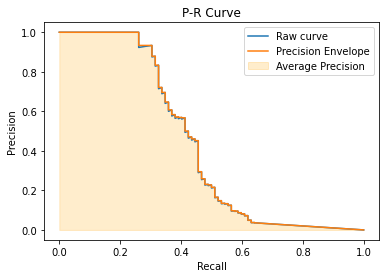

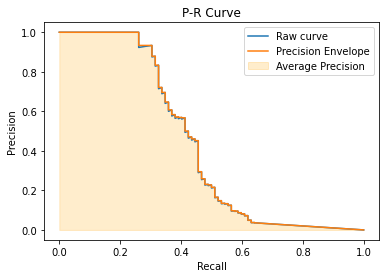

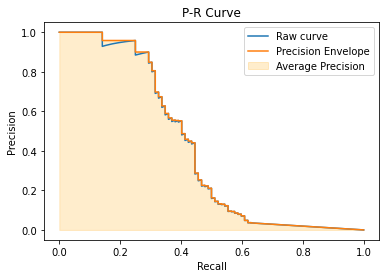

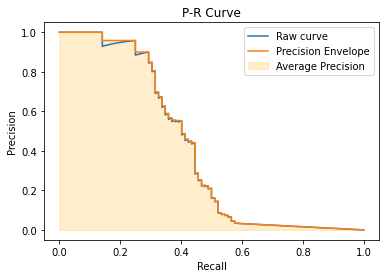

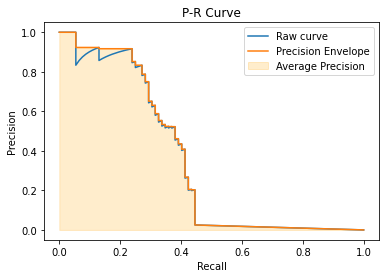

In [10]:
# Traverse over IoU threshold, get AP@[0.5:0.1:0.9]

for iou_thres in np.arange(0.5, 1.0, 0.1):
    ap, prec_raw, prec, recall = compute_ap(df, inputs['num_labels'], iou_thres)
    print('IoU Threshold: {:.2f}'.format(iou_thres), '  |    AP@{:.2f}'.format(iou_thres), ap)
    plot_pr_curves(recall, prec_raw, prec)


## IoU Calculation

Since we have the bottom-left corner of each rectangle as a1 and b1 = (x1,y1), and the top-right corner as a2 and b2 = (x2,y2), we obtain get the maximum values of a1 and b1, giving us the larger x1 and y1 as the bottom-left corner of the intersection region. Similarly, we obtain the minimum values between a2 and b2, giving us the smaller x2 and y2 as the top-right corner of the rectangle.
Using this method, if the two boxes don't intersect, the area of intersection will always be negative, so we use max(0, box_area) in order to set negative values to 0 (intersection area = 0 when no intersection).
Union area is calculated by summing the area od both boxes and subtracting the intersection area.
From there, the IoU is obtained by dividing the intersection area over the union.


## AP trend vs IoU threshold

When we increase the IoU threshold, we can see that the calculated AP value gets smaller, this makes sense since a higher threshold means that we are making a stricter threshold for true positives, meaning that we are likely to have less tp and more fp. This leads to a lower precision and recall, making the area under the P-R curve smaller.
This can be observed in the P-R plots above, where at higher thresholds the precision falls faster, and the maximum value of the recall (excluding the sentinel value of 1) gets smaller.